In [ ]:
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone --unzip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
License(s): copyright-authors
 99% 1.50G/1.52G [00:11<00:00, 145MB/s]
100% 1.52G/1.52G [00:11<00:00, 144MB/s]


In [ ]:
!pip install kaggle

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tqdm import tqdm
import shutil

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Paths
inputFolder = "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
outputFolder = "/content/Output"

# Create subdirectories for train, validation, and test
for split in ['train', 'validation', 'test']:
    for class_name in ['Normal', 'Cyst', 'Tumor', 'Stone']:
        os.makedirs(os.path.join(outputFolder, split, class_name), exist_ok=True)

# Data Preparation
class_names = sorted(os.listdir(inputFolder))
file_paths = []
labels = []

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(inputFolder, class_name)
    for filename in os.listdir(class_path):
        file_paths.append(os.path.join(class_path, filename))
        labels.append(class_idx)

# Stratified split
X_train, X_temp, y_train, y_temp = train_test_split(
    file_paths, labels, test_size=0.3, stratify=labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [ ]:
# Copy Split Data
def copy_files(file_paths, labels, split_name):
    for file_path, label in tqdm(zip(file_paths, labels), total=len(file_paths), desc=f"Copying {split_name} files"):
        class_name = class_names[label]
        filename = os.path.basename(file_path)
        dest_path = os.path.join(outputFolder, split_name, class_name, filename)
        shutil.copy(file_path, dest_path)

# Copy original files
copy_files(X_train, y_train, 'train')
copy_files(X_val, y_val, 'validation')
copy_files(X_test, y_test, 'test')

# Data augmentation for training images
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='reflect'
)

# Generate and save augmented images for training
num_augmentations = 5
target_size = (256, 256)
print("Generating augmented images for training...")
for file_path, label in tqdm(zip(X_train, y_train), total=len(X_train), desc="Augmenting training images"):
    class_name = class_names[label]
    filename = os.path.basename(file_path)
    img = tf.keras.preprocessing.image.load_img(file_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)
    i = 0
    for batch in aug_datagen.flow(img_array, batch_size=1, save_to_dir=os.path.join(outputFolder, 'train', class_name), save_prefix='aug', save_format='jpeg'):
        i += 1
        if i >= num_augmentations:
            break

Copying test files: 100%|██████████| 1867/1867 [00:01<00:00, 1715.45it/s]


Generating augmented images for training...


Augmenting training images: 100%|██████████| 8712/8712 [13:20<00:00, 10.89it/s]


In [ ]:
# Print the number of images in each split and class
for split in ['train', 'validation', 'test']:
    print(f"\n{split.capitalize()} Split (After Augmentation for Train):")
    total = 0
    for class_name in class_names:
        path = os.path.join(outputFolder, split, class_name)
        num_images = len(os.listdir(path))
        print(f"{class_name}: {num_images} images")
        total += num_images
    print(f"Total {split} images: {total}")

# Data generators for training and validation/test
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Class weights
class_counts = np.bincount(labels)
total_samples = sum(class_counts)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

# Print class weights to verify balance
print("Class Weights for Balancing:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_weights[i]:.4f}")

# Create generators
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    os.path.join(outputFolder, 'train'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
val_generator = val_test_datagen.flow_from_directory(
    os.path.join(outputFolder, 'validation'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(outputFolder, 'test'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Print dataset sizes
print(f"Training dataset size (after augmentation): {train_generator.n} images")
print(f"Validation dataset size: {val_generator.n} images")
print(f"Test dataset size: {test_generator.n} images")


Train Split (After Augmentation for Train):
Cyst: 9828 images
Normal: 11856 images
Stone: 4763 images
Tumor: 7098 images
Total train images: 33545

Validation Split (After Augmentation for Train):
Cyst: 556 images
Normal: 762 images
Stone: 206 images
Tumor: 343 images
Total validation images: 1867

Test Split (After Augmentation for Train):
Cyst: 557 images
Normal: 761 images
Stone: 207 images
Tumor: 342 images
Total test images: 1867
Class Weights for Balancing:
Cyst: 0.8389
Normal: 0.6129
Stone: 2.2596
Tumor: 1.3629
Found 33545 images belonging to 4 classes.
Found 1867 images belonging to 4 classes.
Found 1867 images belonging to 4 classes.
Training dataset size (after augmentation): 33545 images
Validation dataset size: 1867 images
Test dataset size: 1867 images


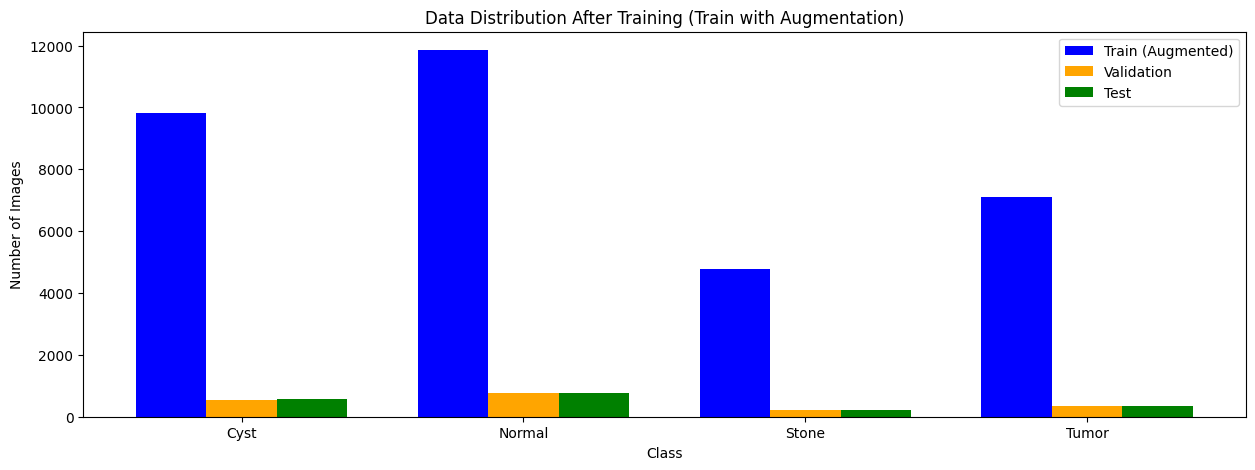

In [ ]:
plt.figure(figsize=(15, 5))
train_counts = [len(os.listdir(os.path.join(outputFolder, 'train', class_name))) for class_name in class_names]
val_counts = [len(os.listdir(os.path.join(outputFolder, 'validation', class_name))) for class_name in class_names]
test_counts = [len(os.listdir(os.path.join(outputFolder, 'test', class_name))) for class_name in class_names]
x = np.arange(len(class_names))
width = 0.25
plt.bar(x - width, train_counts, width, label='Train (Augmented)', color='blue')
plt.bar(x, val_counts, width, label='Validation', color='orange')
plt.bar(x + width, test_counts, width, label='Test', color='green')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Data Distribution After Training (Train with Augmentation)')
plt.xticks(x, class_names)
plt.legend()
plt.show()

In [ ]:
def create_model():
    model = Sequential([
        Conv2D(64, (3,3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D((2,2)),
        Dropout(0.3),
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Dropout(0.4),
        Conv2D(256, (3,3), activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3,3), activation='relu'),
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'auc']
    )
    return model

model = create_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
callbacks = [
    EarlyStopping(patience=15, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
]

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1049/1049 ━━━━━━━━━━━━━━━━━━━━ 320s 278ms/step - accuracy: 0.4667 - auc: 0.7428 - loss: 1.3419 - val_accuracy: 0.5795 - val_auc: 0.8176 - val_loss: 1.0958 - learning_rate: 0.0010
Epoch 2/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 267s 255ms/step - accuracy: 0.6736 - auc: 0.8949 - loss: 0.8229 - val_accuracy: 0.5335 - val_auc: 0.8041 - val_loss: 1.6139 - learning_rate: 0.0010
Epoch 3/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 265s 252ms/step - accuracy: 0.8448 - auc: 0.9693 - loss: 0.4100 - val_accuracy: 0.9277 - val_auc: 0.9929 - val_loss: 0.1918 - learning_rate: 0.0010
Epoch 4/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 324s 254ms/step - accuracy: 0.9070 - auc: 0.9875 - loss: 0.2572 - val_accuracy: 0.9432 - val_auc: 0.9919 - val_loss: 0.1820 - learning_rate: 0.0010
Epoch 5/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 265s 253ms/step - accuracy: 0.9287 - auc: 0.9913 - loss: 0.2008 - val_accuracy: 0.9855 - val_auc: 0.9992 - val_loss: 0.0501 - learning_rate: 0.0010
Epoch 6/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 264s 252ms/step - a

59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step


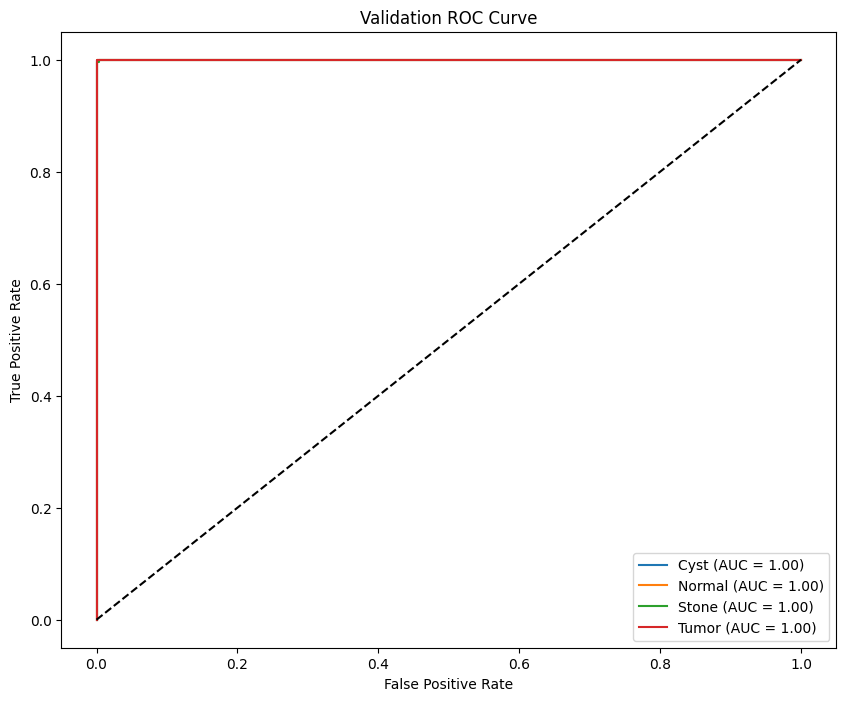

In [ ]:
best_model = tf.keras.models.load_model('best_model.keras')

# Validation predictions
y_pred = best_model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f'{name} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend()
plt.show()

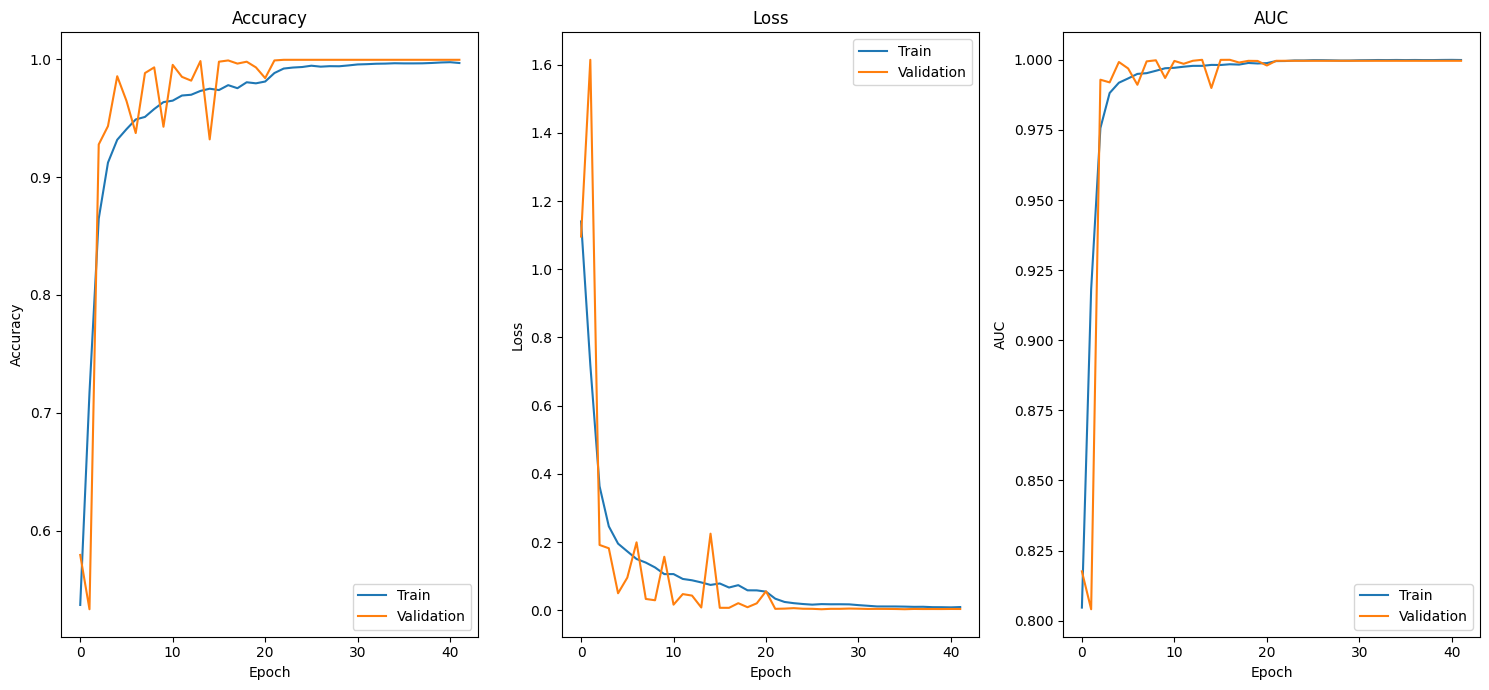

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train')
plt.plot(history.history['val_auc'], label='Validation')
plt.title('AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

Found 1867 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - accuracy: 0.9997 - auc: 0.9999 - loss: 0.0017
Test Loss: 0.0061
Test Accuracy: 0.9989
Test AUC: 0.9996
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step


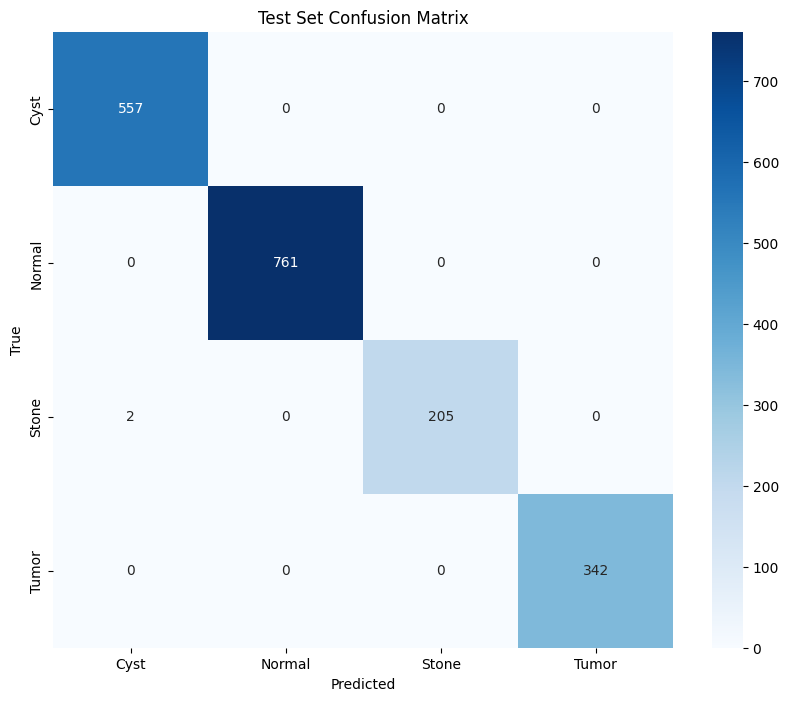

Test Set Classification Report:
              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       557
      Normal       1.00      1.00      1.00       761
       Stone       1.00      0.99      1.00       207
       Tumor       1.00      1.00      1.00       342

    accuracy                           1.00      1867
   macro avg       1.00      1.00      1.00      1867
weighted avg       1.00      1.00      1.00      1867



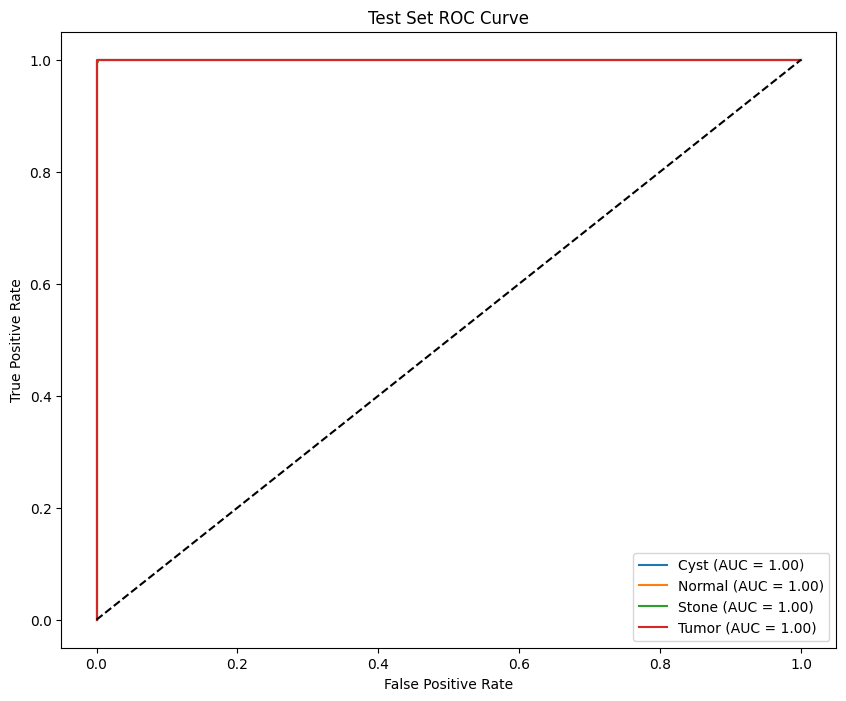

In [ ]:
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(outputFolder, 'test'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate test set
test_loss, test_accuracy, test_auc = best_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Test predictions for confusion matrix and classification report
y_test_pred = best_model.predict(test_generator)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = test_generator.classes

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test_true, y_test_pred_classes), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()

# Classification Report
print("Test Set Classification Report:")
print(classification_report(y_test_true, y_test_pred_classes, target_names=class_names))

# Test ROC Curve
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()
for i in range(len(class_names)):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_true == i, y_test_pred[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

plt.figure(figsize=(10, 8))
for i, name in enumerate(class_names):
    plt.plot(fpr_test[i], tpr_test[i], label=f'{name} (AUC = {roc_auc_test[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curve')
plt.legend()
plt.show()

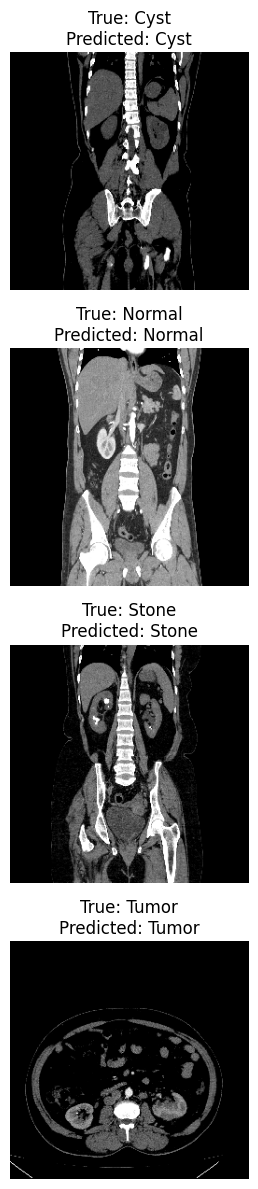

In [ ]:
def predict_per_class_samples(model, generator, class_names, num_classes=4):
    generator.reset()
    images_per_class = []
    labels_per_class = []
    found_classes = set()
    while len(found_classes) < num_classes:
        imgs, lbls = next(generator)
        for img, lbl in zip(imgs, lbls):
            cls_idx = np.argmax(lbl)
            if cls_idx not in found_classes:
                images_per_class.append(img)
                labels_per_class.append(lbl)
                found_classes.add(cls_idx)
            if len(found_classes) >= num_classes:
                break

    plt.figure(figsize=(15, 3 * num_classes))
    for i, (img, lbl) in enumerate(zip(images_per_class, labels_per_class)):
        true_label = class_names[np.argmax(lbl)]
        img_processed = np.expand_dims(img, axis=0)
        pred = model.predict(img_processed, verbose=0)
        pred_label = class_names[np.argmax(pred)]
        plt.subplot(num_classes, 1, i + 1)
        plt.imshow(img)
        plt.title(f'True: {true_label}\nPredicted: {pred_label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

class_names = list(test_generator.class_indices.keys())
predict_per_class_samples(best_model, test_generator, class_names, num_classes=4)